# Import Data

In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math as math
import scikitplot as skplt

sns.set(style="white", palette="pastel",font_scale=1.5, rc={"lines.linewidth": 2.5,'figure.figsize':(11.7,8.27)})
pd.options.display.max_columns = None

In [121]:
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, KFold, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, confusion_matrix, fbeta_score, classification_report, adjusted_rand_score, adjusted_mutual_info_score 
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier,StackingClassifier, IsolationForest, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from pprint import pprint
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

In [122]:
df_combined = pd.read_csv("data/exported/df_combined.csv", index_col = 0)
df_not_combined = pd.read_csv("data/exported/df_not_combined.csv", index_col = 0)
df_yeast_not_combined = pd.read_csv("data/exported/df_yeast_not_combined.csv", index_col = 0)
df_yeast_combined = pd.read_csv("data/exported/df_yeast_combined.csv", index_col = 0)

C:\Users\neomo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (4,13,14,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [123]:
df_not_combined = df_not_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category","modified_status":"category"})
df_not_combined = df_not_combined.astype({"ref_number":"object"})

In [124]:
df_combined = df_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category","modified_status":"category",
                                  "modified_status_rolling_max":"object"})
df_combined = df_combined.astype({"ref_number":"object"})

In [125]:
df_yeast_not_combined = df_yeast_not_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category"})
df_yeast_not_combined = df_yeast_not_combined.astype({"ref_number":"object"})

In [126]:
df_yeast_combined = df_yeast_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category"})
df_yeast_combined = df_yeast_combined.astype({"ref_number":"object"})

# train test split

In [127]:
# manual train test split according to ref_num to preserve sequence sequence identity
# maybe do it according to read_num to increase variability?

final_ref = ["ref_0000","ref_0001","ref_0002","ref_0003"]
val_ref = ["ref_0004"]
train_ref = ["ref_0000","ref_0001","ref_0002"]
test_ref = ["ref_0003"]

In [128]:
seed = 7

## not_combined

In [129]:
X_finaltest_not_combined = df_not_combined[df_not_combined["ref_number"].isin(final_ref)]
y_finaltest_not_combined = X_finaltest_not_combined.pop("modified_status")
X_val_not_combined = df_not_combined[df_not_combined["ref_number"].isin(val_ref)]
y_val_not_combined = X_val_not_combined.pop("modified_status")
X_train_not_combined = df_not_combined[df_not_combined["ref_number"].isin(train_ref)]
y_train_not_combined = X_train_not_combined.pop("modified_status")
X_test_not_combined = df_not_combined[df_not_combined["ref_number"].isin(test_ref)]
y_test_not_combined = X_test_not_combined.pop("modified_status")

In [130]:
numeric_features_not_combined = list(X_train_not_combined.columns[X_train_not_combined.dtypes ==  "float"])

In [131]:
numeric_features_not_combined

['dwell_time',
 'median_value',
 'dwell_time_rolling_median',
 'median_value_rolling_median',
 'dwell_time_rolling_min',
 'median_value_rolling_min']

In [132]:
cat_features_not_combined = list(X_train_not_combined.columns[X_train_not_combined.dtypes ==  "category"])

In [133]:
cat_features_not_combined

['base_1', 'base_2', 'base_3', 'base_4', 'base_5']

In [134]:
#preprocessing pipeline to scale numeric and onehot encode categorical values
imputer1_not_combined = SimpleImputer(strategy="median")
scaler1_not_combined = StandardScaler()
numeric_transformer_not_combined = make_pipeline(imputer1_not_combined,scaler1_not_combined)


imputer2_not_combined = SimpleImputer(strategy='constant', fill_value='missing')
encoder_not_combined = OneHotEncoder(handle_unknown='error')
cat_transformer_not_combined = make_pipeline(imputer2_not_combined,encoder_not_combined)

preprocessor_not_combined = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_not_combined, numeric_features_not_combined),
        ('cat', cat_transformer_not_combined, cat_features_not_combined)
    ])

### preprocessor without bases

In [135]:
#preprocessing pipeline to scale numeric and onehot encode categorical values


preprocessor_not_combined_wo_bases = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_not_combined, numeric_features_not_combined)
    ])

## combined

In [136]:
X_finaltest_combined = df_combined[df_combined["ref_number"].isin(final_ref)]
y_finaltest_combined = X_finaltest_combined.pop("modified_status")
X_val_combined = df_combined[df_combined["ref_number"].isin(val_ref)]
y_val_combined = X_val_combined.pop("modified_status")
X_train_combined = df_combined[df_combined["ref_number"].isin(train_ref)]
y_train_combined = X_train_combined.pop("modified_status")
X_test_combined = df_combined[df_combined["ref_number"].isin(test_ref)]
y_test_combined = X_test_combined.pop("modified_status")

In [137]:
numeric_features_combined = list(X_train_combined .columns[X_train_combined .dtypes ==  "float"])

In [138]:
numeric_features_combined

['dwell_time_median',
 'dwell_time_std',
 'dwell_time_min',
 'dwell_time_max',
 'median_value_median',
 'median_value_std',
 'median_value_min',
 'median_value_max',
 'dwell_time_rolling_median',
 'median_value_rolling_median',
 'dwell_time_rolling_min',
 'median_value_rolling_min']

In [139]:
cat_features_combined = list(X_train_combined.columns[X_train_combined.dtypes ==  "category"])

In [140]:
cat_features_combined

['base_1', 'base_2', 'base_3', 'base_4', 'base_5']

In [141]:
imputer1_combined = SimpleImputer(strategy="median")
scaler1_combined = StandardScaler()
numeric_transformer_combined = make_pipeline(imputer1_combined,scaler1_combined)


imputer2_combined = SimpleImputer(strategy='constant', fill_value='missing')
encoder_combined = OneHotEncoder(handle_unknown='error')
cat_transformer_combined = make_pipeline(imputer2_combined,encoder_combined)

preprocessor_combined = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_combined, numeric_features_combined),
        ('cat', cat_transformer_combined, cat_features_combined)
    ])

In [142]:
labels = X_finaltest_not_combined.ref_number.values
cv_by_hand = [(np.where(labels != label)[0], np.where(labels == label)[0])
               for label in np.unique(labels)]

# supervised

In [143]:
# model selector class to choose models

class ModelSelector():
    
    def __init__(self, preprocessor,cv_state =True, sampler=None, instance_name=None):
        # initialise class with predetrmined models and tests, maybe add functions to add/change them afterwards?
        # add option to use a sampler (default = none)
        self.results = []
        self.name = []
        self.preprocessor = preprocessor
        self.sampler = sampler
        self.cv = []
        self.labels = []
        self.cv_state = cv_state
        self.scoring = {'precision':'precision',
                        'recall': 'recall',
                        'f1score':'f1',
                        'roc auc':'roc_auc'}
        self.models = [
                        ('LR', LogisticRegression(random_state=seed, max_iter = 1000, n_jobs=-1)),
                        ('KNN', KNeighborsClassifier(n_jobs = -1)),
                        ('RF', RandomForestClassifier(random_state=seed, n_jobs = -1)),
                        ('ADAB', AdaBoostClassifier(random_state=seed)),
                        ('XGB',  XGBClassifier(random_state=seed, n_jobs = -1)),
                        ('SVC', SVC(random_state=seed)),
                        ('GNB', GaussianNB()),
                        ('MLP', MLPClassifier(random_state=seed))
                    ]
        self.instance_name = instance_name
        self.tests = ["test_"+elm for elm in self.scoring.keys()]
        self.best_results= []


    # function for determining the cvs, if True do cv for each ref_num
    def __cv__(self, X):
        if self.cv_state == True:
            self.labels = X.ref_number.values
            self.cv = [(np.where(self.labels != label)[0], np.where(self.labels == label)[0]) for label in np.unique(self.labels)]
        else:
            self.cv = 5
   

    # fit each model and do cv and record cvs and names
    def select_model(self, X, y, state):
        self.cv_state = state
        self.__cv__(X)
        for name, model in self.models:
            model_pipe = Pipeline([(self.preprocessor.__class__.__name__,self.preprocessor),
                                   (self.sampler.__class__.__name__,self.sampler),("name",model)])
            cv_results = cross_validate(model_pipe, X, y, cv=self.cv, scoring=self.scoring, n_jobs=-1, return_train_score=True)
            self.results.append(cv_results)
            self.name.append(name)
    
    def plot_selection(self):
        # plot the test scores for each test and each model
        plt.figure(figsize = (15,8))
        plt.suptitle('Algorithm Comparison for ' + self.instance_name)
        for idx, test in enumerate(self.tests):
            temp_results = [self.results[i][test] for i in range(len(self.results))]
            plt.subplot(1,len(self.tests),idx+1)
            sns.boxplot(y = temp_results, x = self.name)
            plt.title(test)
            plt.xticks(rotation = 90)
            plt.ylim(0,1.05)
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
    
    def get_scores(self, top = 3):
        
        for idx, test in enumerate(self.tests):
            temp_results = [np.mean(self.results[i][test]) for i in range(len(self.results))]
            test_name = [test for i in range(len(self.name))]
            instance_name = [self.instance_name for i in range (len(self.name))]
            temp_best = sorted(zip(temp_results,self.name,test_name, instance_name), reverse = True)[:top]
            self.best_results.append(temp_best)
            
        test= pd.DataFrame()
        for i in range(np.array(self.best_results).shape[0]): 
            test= pd.concat([test, pd.DataFrame(np.array(self.best_results)[i])], axis=0)
        test.columns = ["test_result","model","test", "instance_name"]
        test.test_result = test.test_result.astype(float)
        test.set_index(["instance_name","test","model"], inplace = True)
        return(test)

In [144]:
model_selection_results = pd.DataFrame()

In [145]:
def modified_ratio(X, y, threshold = 0):
    
    modified_pos = []
    modified_pos_ratio = []
    y_pred_ref_pos = X.ref_pos.values
    ratio_df = pd.DataFrame(pd.concat([pd.Series(y),pd.Series(y_pred_ref_pos)],axis=1))
    ratio_df.columns =["predicted","ref_pos"]
    for elm in ratio_df.ref_pos.unique():
        msk = ratio_df[ratio_df.ref_pos == elm]
        ratio = round((len(msk[msk.predicted == 1])/len(msk))*100,2)
        if ratio > threshold:
            print("Ratio of modified Reads for ref_pos " + str(elm) + " is :" + str(ratio))
            modified_pos.append(elm)
            modified_pos_ratio.append(ratio)
    df = pd.DataFrame({"ratio":modified_pos_ratio}, index = modified_pos )
    df.index.rename("ref_pos",inplace=True)
    return (df)

In [146]:
def feature_importances (model, preprocessor, X, y, debug = False):

    cat_features = list(X.columns[X.dtypes ==  "category"])
    numeric_features = list(X.columns[X.dtypes ==  "float"])
    cat = None
    if "base_1" in X.columns:
        bases = ["_A","_C","_T","_G"]
        cat = [elm + base for elm in cat_features_not_combined for base in bases ]
    X_trans = preprocessor.fit_transform(X)
    feature_names = numeric_features + cat
    if debug:
        print(feature_names)
        print(len(feature_names))
    model.fit(X_trans, y)
  
    skplt.estimators.plot_feature_importances(model, feature_names=feature_names, max_num_features=10)
    plt.xticks(rotation=90);

In [ ]:
def evaluation (model,X, y, thresh = 30):
    y_pred=model.predict(X)
    skplt.metrics.plot_confusion_matrix(y, y_pred, figsize=(10,10), text_fontsize=20)
    print("-"*30)
    print(classification_report(y,y_pred))
    print("-"*30)
    ratio = modified_ratio(X,y_pred, thresh)
    print("-"*30)
    return ratio

## baseline

In [147]:
y_pred = np.zeros(len(X_val_not_combined))

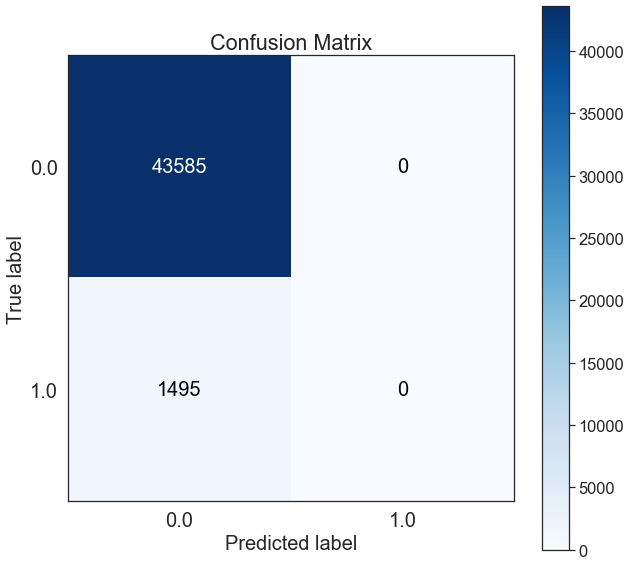

In [148]:
skplt.metrics.plot_confusion_matrix(y_val_not_combined, y_pred, figsize=(10,10), text_fontsize=20)

In [29]:
print(classification_report(y_val_not_combined,y_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     43585
         1.0       0.00      0.00      0.00      1495

    accuracy                           0.97     45080
   macro avg       0.48      0.50      0.49     45080
weighted avg       0.93      0.97      0.95     45080



C:\Users\neomo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## classical ml models

### model selection

In [30]:
sel = ModelSelector(preprocessor_not_combined, instance_name = "Uncombined Dataframe")

In [31]:
sel.select_model(X_finaltest_not_combined, y_finaltest_not_combined, True)

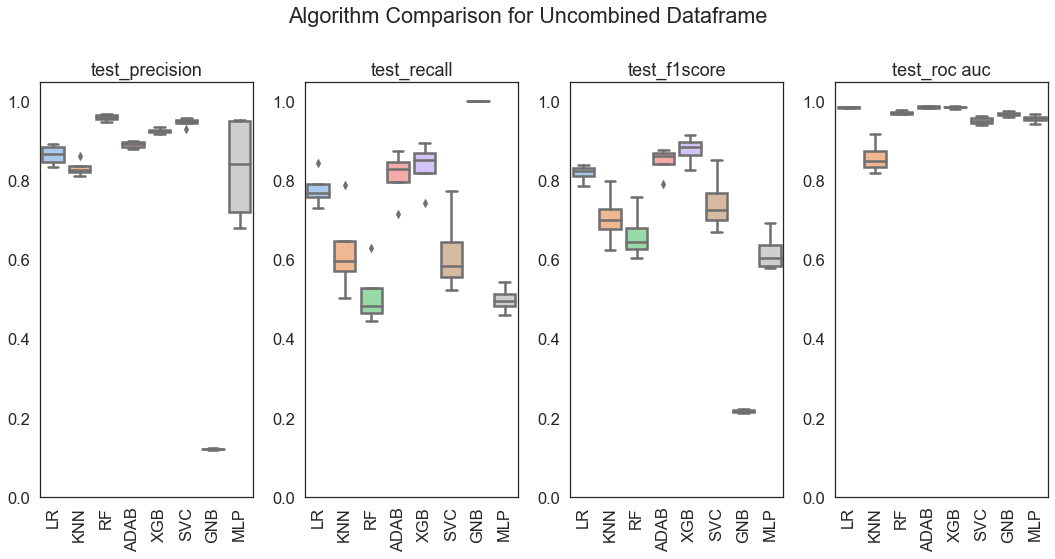

In [32]:
sel.plot_selection()

In [33]:
model_selection_results = pd.concat([model_selection_results,sel.get_scores()], axis=0)

### xgb gridsearch

In [171]:
param_grid_xgb = {'xgbclassifier__max_depth':[1],
                 'xgbclassifier__learning_rate':[0.2],
                 'xgbclassifier__n_estimators':[500],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0]}

In [172]:
xgb_clf = XGBClassifier(n_jobs=4,random_state=seed)
model_xgb = make_pipeline(preprocessor_not_combined,xgb_clf)

In [173]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)
grid_xgb.fit(X_finaltest_not_combined, y_finaltest_not_combined)
print(grid_xgb.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.4s finished


{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__max_depth': 1, 'xgbclassifier__n_estimators': 500}


------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     43585
         1.0       0.91      0.86      0.88      1495

    accuracy                           0.99     45080
   macro avg       0.95      0.93      0.94     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :45.22
Ratio of modified Reads for ref_pos 43 is :45.22
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 65 is :30.43
Ratio of modified Reads for ref_pos 75 is :45.22
Ratio of modified Reads for ref_pos 81 is :45.22
Ratio of modified Reads for ref_pos 104 is :45.22
Ratio of modified Reads for ref_pos 123 is :44.78
Ratio of modified Reads for ref_pos 163 is :45.22
Ratio of modified Reads for ref_pos 169 is :32.61
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified 

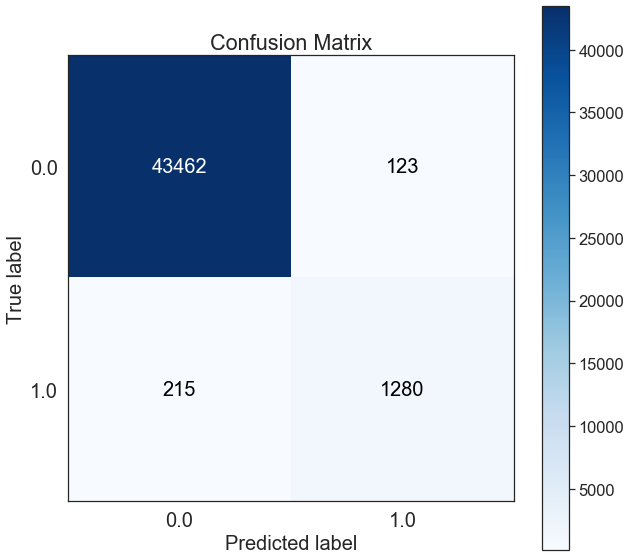

In [174]:
modified_ratio_uncombined = evaluation(grid_xgb, X_val_not_combined, y_val_not_combined)

### ADABoost Gridsearch

In [180]:
param_grid_ada = {'adaboostclassifier__algorithm':['SAMME.R'],
                  'adaboostclassifier__learning_rate':[0.05],
                 'adaboostclassifier__n_estimators':[60]}

In [181]:
ada_clf = AdaBoostClassifier(random_state=seed)
model_ada = make_pipeline(preprocessor_not_combined,ada_clf)

In [182]:
grid_ada = GridSearchCV(model_ada, param_grid_ada, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)
grid_ada.fit(X_finaltest_not_combined, y_finaltest_not_combined)
print(grid_ada.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.3s finished


{'adaboostclassifier__algorithm': 'SAMME.R', 'adaboostclassifier__learning_rate': 0.05, 'adaboostclassifier__n_estimators': 60}


------------------------------
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     43585
         1.0       0.92      0.84      0.88      1495

    accuracy                           0.99     45080
   macro avg       0.96      0.92      0.94     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :43.91
Ratio of modified Reads for ref_pos 43 is :45.22
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 65 is :31.3
Ratio of modified Reads for ref_pos 75 is :45.22
Ratio of modified Reads for ref_pos 81 is :39.57
Ratio of modified Reads for ref_pos 104 is :45.22
Ratio of modified Reads for ref_pos 123 is :45.22
Ratio of modified Reads for ref_pos 163 is :38.26
Ratio of modified Reads for ref_pos 169 is :38.7
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified Re

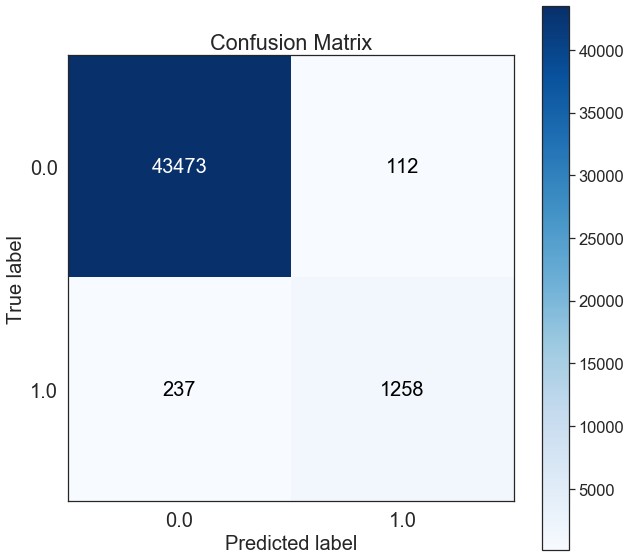

In [183]:
modified_ratio_uncombined_ada = evaluation(grid_ada, X_val_not_combined, y_val_not_combined)

### logit gridsearch

In [175]:
class_weight_list = compute_class_weight("balanced", df_not_combined.modified_status.unique(),df_not_combined.modified_status.values) 
class_weight = dict(zip(df_not_combined.modified_status.unique(), class_weight_list))

In [176]:
param_grid_logit = {'logisticregression__penalty':['l1'],
                    'logisticregression__dual':[False],
                    'logisticregression__tol':[0.0001],
                    'logisticregression__C':[2.0],
                    'logisticregression__fit_intercept':[False],
                    'logisticregression__class_weight':[None],
                    'logisticregression__solver':['liblinear']
                   }

In [177]:
logit_clf = LogisticRegression(random_state=seed, max_iter = 1000, n_jobs=-1)
model_logit = make_pipeline(preprocessor_not_combined,logit_clf)

In [178]:
grid_logit = GridSearchCV(model_logit, param_grid_logit, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)
grid_logit.fit(X_finaltest_not_combined, y_finaltest_not_combined)
print(grid_logit.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.5s finished
C:\Users\neomo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


{'logisticregression__C': 2.0, 'logisticregression__class_weight': None, 'logisticregression__dual': False, 'logisticregression__fit_intercept': False, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear', 'logisticregression__tol': 0.0001}


------------------------------
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     43585
         1.0       0.87      0.78      0.82      1495

    accuracy                           0.99     45080
   macro avg       0.93      0.89      0.91     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :45.65
Ratio of modified Reads for ref_pos 43 is :44.78
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 75 is :39.13
Ratio of modified Reads for ref_pos 81 is :45.65
Ratio of modified Reads for ref_pos 104 is :44.78
Ratio of modified Reads for ref_pos 123 is :42.17
Ratio of modified Reads for ref_pos 163 is :45.22
Ratio of modified Reads for ref_pos 179 is :44.78
Ratio of modified Reads for ref_pos 185 is :43.91
------------------------------


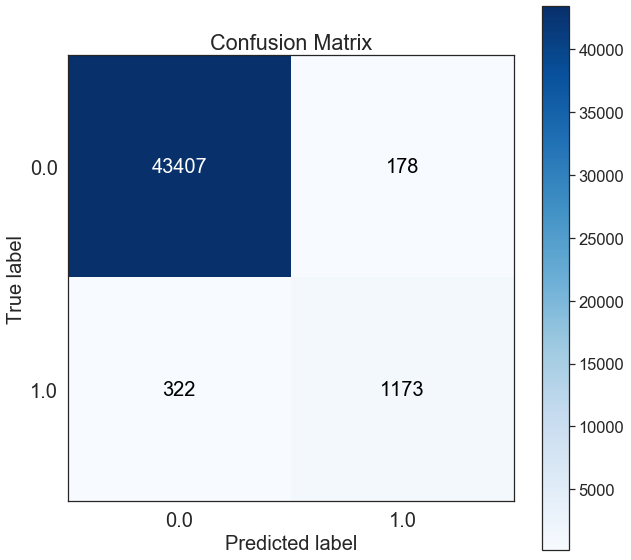

In [179]:
modified_ratio_uncombined_logit = evaluation(grid_logit, X_val_not_combined, y_val_not_combined)

### Stacking

In [189]:
labels = X_finaltest_not_combined.ref_number.values
cv_by_hand = [(np.where(labels != label)[0], np.where(labels == label)[0])
               for label in np.unique(labels)]

In [190]:
xgb_clf = XGBClassifier(n_jobs=4,random_state=seed, max_depth=1, learning_rate=0.2, n_estimators=500, gamma=0)
model_xgb = make_pipeline(preprocessor_not_combined,xgb_clf)

In [191]:
ada_clf = AdaBoostClassifier(random_state=seed, n_estimators=60, learning_rate=0.05)
model_ada = make_pipeline(preprocessor_not_combined,ada_clf)

In [192]:
logit_clf = LogisticRegression(random_state=seed, max_iter = 1000, n_jobs=-1, penalty='l1', tol=0.001, C=2.0, fit_intercept=False, solver='liblinear')
model_logit = make_pipeline(preprocessor_not_combined,logit_clf)

In [193]:
estimators = [("XGB", model_xgb),("ADA",model_ada),("logit",model_logit)]
stack_clf = StackingClassifier(estimators, cv = cv_by_hand, final_estimator = LogisticRegression(), n_jobs=-1)

In [196]:
%%capture
stack_clf.fit(X_finaltest_not_combined, y_finaltest_not_combined)

------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     43585
         1.0       0.92      0.86      0.88      1495

    accuracy                           0.99     45080
   macro avg       0.96      0.93      0.94     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :45.22
Ratio of modified Reads for ref_pos 43 is :45.22
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 65 is :30.87
Ratio of modified Reads for ref_pos 75 is :45.22
Ratio of modified Reads for ref_pos 81 is :44.35
Ratio of modified Reads for ref_pos 104 is :45.22
Ratio of modified Reads for ref_pos 123 is :45.22
Ratio of modified Reads for ref_pos 163 is :43.91
Ratio of modified Reads for ref_pos 169 is :34.78
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified 

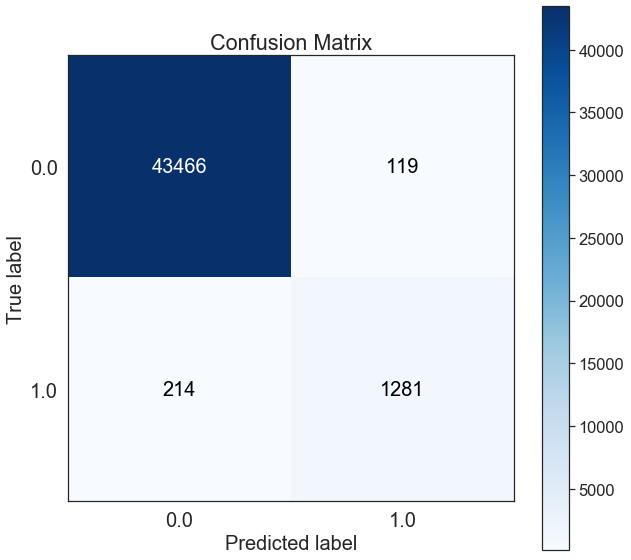

In [197]:
modified_ratio_uncombined_stack = evaluation(stack_clf, X_val_not_combined, y_val_not_combined)

### Voting

In [198]:
vote_clf = VotingClassifier(estimators, n_jobs=-1, voting='hard')

In [199]:
%%capture
vote_clf.fit(X_finaltest_not_combined, y_finaltest_not_combined)

------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     43585
         1.0       0.92      0.86      0.89      1495

    accuracy                           0.99     45080
   macro avg       0.96      0.93      0.94     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :45.22
Ratio of modified Reads for ref_pos 43 is :45.22
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 65 is :30.43
Ratio of modified Reads for ref_pos 75 is :45.22
Ratio of modified Reads for ref_pos 81 is :45.22
Ratio of modified Reads for ref_pos 104 is :45.22
Ratio of modified Reads for ref_pos 123 is :44.78
Ratio of modified Reads for ref_pos 163 is :45.22
Ratio of modified Reads for ref_pos 169 is :33.48
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified 

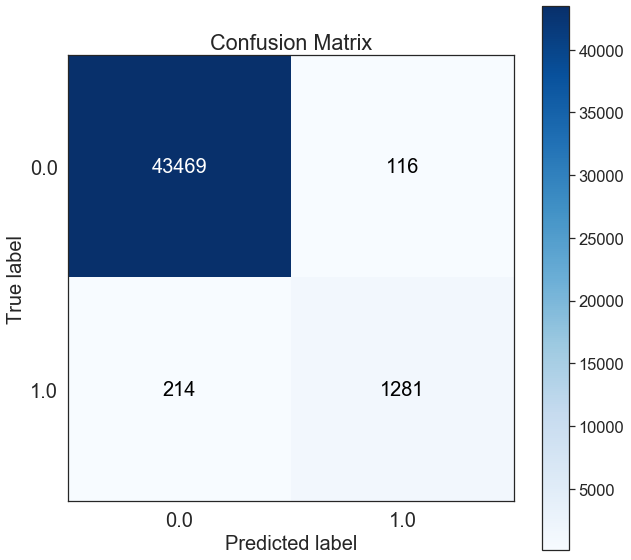

In [200]:
modified_ratio_uncombined_vote = evaluation(vote_clf, X_val_not_combined, y_val_not_combined)

### feature importances

In [73]:
xgb = XGBClassifier(n_jobs=4,random_state=seed, gamma= 0, learning_rate = 0.2,
                        max_depth= 1, n_estimators = 500)

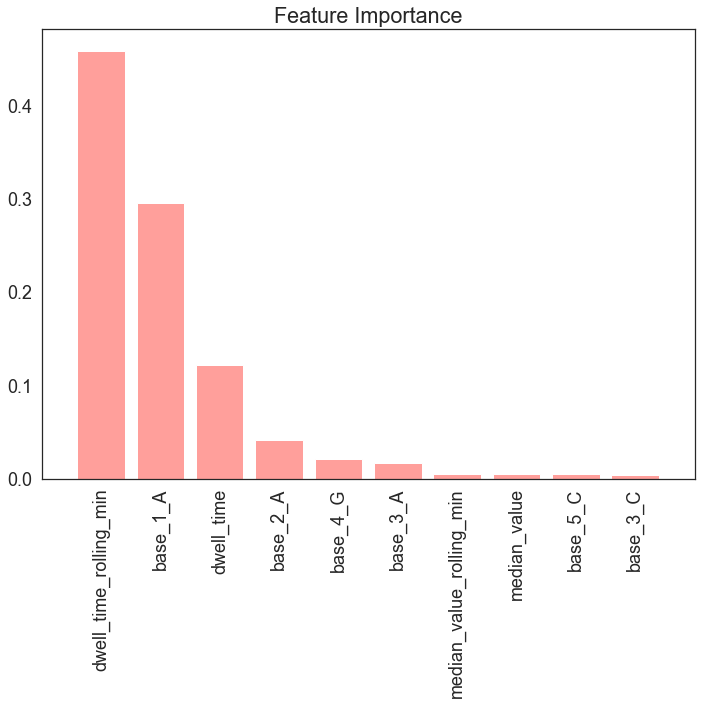

In [80]:
feature_importances(xgb, preprocessor_not_combined, X_finaltest_not_combined, y_finaltest_not_combined)

### yeast dataset prediction

In [77]:
X_yeast_trans = preprocessor_not_combined.fit_transform(df_yeast_not_combined)

In [78]:
y_yeast_pred = xgb.predict(X_yeast_trans)

In [79]:
df_yeast_not_combined["modified_status_predicted"] = y_yeast_pred

In [80]:
df_yeast_group = df_yeast_not_combined.file_type.groupby(
    df_yeast_not_combined["modified_status_predicted"]).value_counts(normalize=True).rename("wt_ko_ratio").reset_index()

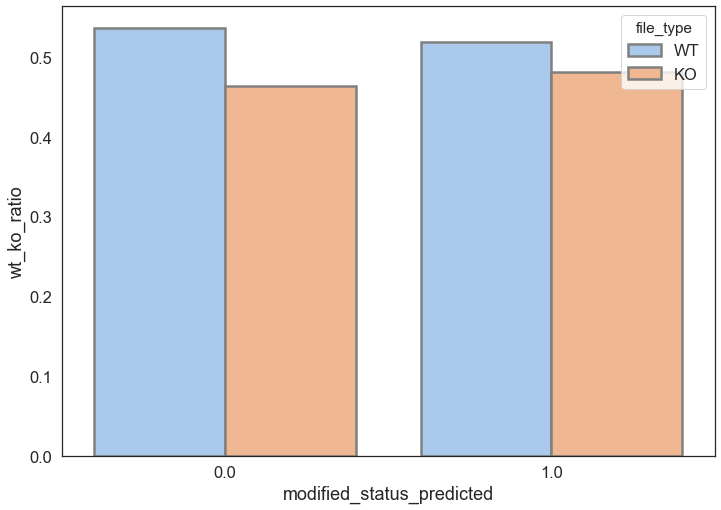

In [81]:
sns.barplot(data = df_yeast_group, x = "modified_status_predicted",y = "wt_ko_ratio", hue = "file_type"
            ,edgecolor="grey" , linewidth = 2.5 );

In [82]:
df_yeast_group

,modified_status_predicted,file_type,wt_ko_ratio
0,0.0,WT,0.536529
1,0.0,KO,0.463471
2,1.0,WT,0.518519
3,1.0,KO,0.481481


## Classical ml models with Oversampling

In [204]:
smotet = SMOTETomek(sampling_strategy = 'minority', random_state = seed, n_jobs = -1)


### model selection

In [84]:
sel_os = ModelSelector(preprocessor_not_combined, smotet, instance_name = "Uncombined Dataframe and Oversampling")

sel_os.select_model(X_finaltest_not_combined, y_finaltest_not_combined, True)

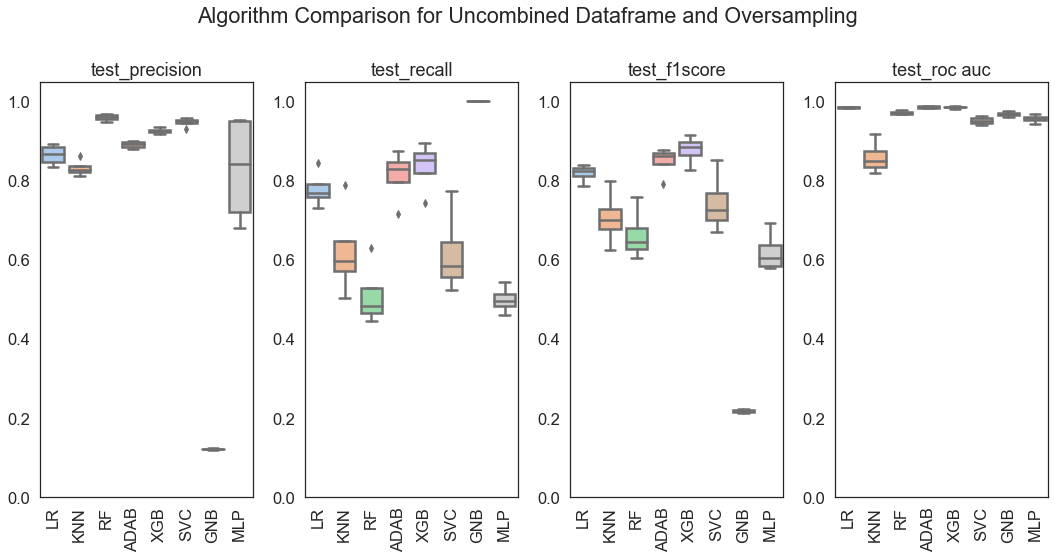

In [85]:
sel_os.plot_selection()

In [86]:
model_selection_results = pd.concat([model_selection_results,sel_os.get_scores()], axis=0)

### xgb gridsearch

In [205]:
param_grid_xgb = {'xgbclassifier__max_depth':[5],
                 'xgbclassifier__learning_rate':[0.1],
                 'xgbclassifier__n_estimators':[5],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0]}

In [206]:
xgb_clf = XGBClassifier(n_jobs = -1,random_state=seed)
model_xgb = Pipeline([("transformer",preprocessor_not_combined),("smt",smotet),("xgbclassifier",xgb_clf)])

In [207]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)
grid_xgb.fit(X_finaltest_not_combined, y_finaltest_not_combined)
print(grid_xgb.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   30.7s finished


{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 5}


------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     43585
         1.0       0.86      0.90      0.88      1495

    accuracy                           0.99     45080
   macro avg       0.93      0.95      0.94     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.65
Ratio of modified Reads for ref_pos 26 is :45.22
Ratio of modified Reads for ref_pos 43 is :45.22
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 65 is :45.65
Ratio of modified Reads for ref_pos 75 is :45.22
Ratio of modified Reads for ref_pos 81 is :43.48
Ratio of modified Reads for ref_pos 104 is :45.22
Ratio of modified Reads for ref_pos 123 is :45.22
Ratio of modified Reads for ref_pos 163 is :45.22
Ratio of modified Reads for ref_pos 169 is :45.22
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified 

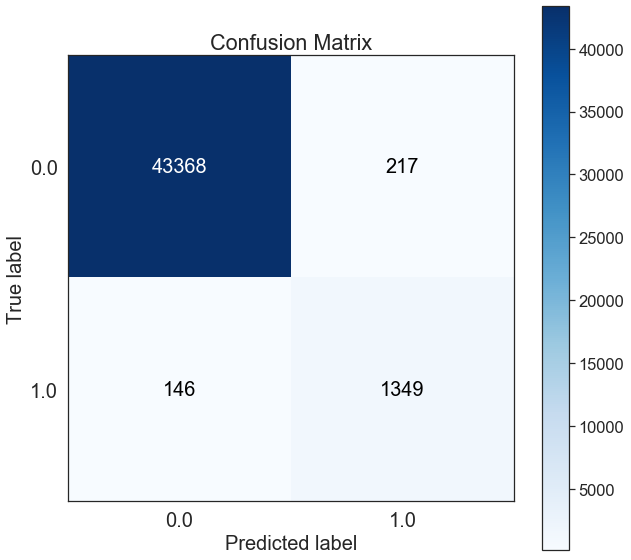

In [208]:
modified_ratio_uncombined_os = evaluation(grid_xgb, X_val_not_combined, y_val_not_combined)

## Classical ml models (dwell time polynomial)

In [30]:
poly = PolynomialFeatures(10)

In [31]:
X_poly = np.array(df_not_combined.dwell_time + 1)
X_poly = pd.DataFrame(poly.fit_transform(X_poly.reshape(-1,1)))
cols = ["dwell_time_poly_" + str(elm) for elm in list(X_poly.columns)]
X_poly.columns = cols
df_poly = pd.concat([df_not_combined, X_poly], axis = 1)

In [32]:
X_finaltest_poly = df_poly[df_poly["ref_number"].isin(final_ref)]
y_finaltest_poly = X_finaltest_poly.pop("modified_status")
X_val_poly = df_poly[df_poly["ref_number"].isin(val_ref)]
y_val_poly = X_val_poly.pop("modified_status")
X_train_poly = df_poly[df_poly["ref_number"].isin(train_ref)]
y_train_poly = X_train_poly.pop("modified_status")
X_test_poly = df_poly[df_poly["ref_number"].isin(test_ref)]
y_test_poly = X_test_poly.pop("modified_status")

In [33]:
numeric_features_poly = list(X_train_poly.columns[X_train_poly.dtypes ==  "float"])

In [35]:
cat_features_poly = list(X_train_poly.columns[X_train_poly.dtypes ==  "category"])

In [37]:
#preprocessing pipeline to scale numeric and onehot encode categorical values
imputer1_poly = SimpleImputer(strategy="median")
scaler1_poly = StandardScaler()
numeric_transformer_poly = make_pipeline(imputer1_poly,scaler1_poly)


imputer2_poly = SimpleImputer(strategy='constant', fill_value='missing')
encoder_poly = OneHotEncoder(handle_unknown='error')
cat_transformer_poly = make_pipeline(imputer2_poly,encoder_poly)

preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly, numeric_features_poly),
        ('cat', cat_transformer_poly, cat_features_poly)
    ])

### model selection

In [38]:
sel_poly = ModelSelector(preprocessor_poly, instance_name = "Uncombined Dataframe and Polynomial Dwell Time")

sel_poly.select_model(X_finaltest_poly, y_finaltest_poly, True)

KeyboardInterrupt: 

In [ ]:
sel_poly.plot_selection()

In [103]:
model_selection_results = pd.concat([model_selection_results,sel_poly.get_scores()], axis=0)

### xgb gridsearch

In [209]:
param_grid_xgb = {'xgbclassifier__max_depth':[1],
                 'xgbclassifier__learning_rate':[0.2],
                 'xgbclassifier__n_estimators':[500],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0]}

In [210]:
xgb_clf = XGBClassifier(n_jobs = -1,random_state=seed)
model_xgb = Pipeline([("transformer",preprocessor_poly),("xgbclassifier",xgb_clf)])

In [211]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)
grid_xgb.fit(X_finaltest_poly, y_finaltest_poly)
print(grid_xgb.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   40.7s finished


{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__max_depth': 1, 'xgbclassifier__n_estimators': 500}


------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     43585
         1.0       0.91      0.86      0.88      1495

    accuracy                           0.99     45080
   macro avg       0.95      0.93      0.94     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :45.22
Ratio of modified Reads for ref_pos 43 is :45.22
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 65 is :30.43
Ratio of modified Reads for ref_pos 75 is :45.22
Ratio of modified Reads for ref_pos 81 is :45.22
Ratio of modified Reads for ref_pos 104 is :45.22
Ratio of modified Reads for ref_pos 123 is :44.78
Ratio of modified Reads for ref_pos 163 is :45.22
Ratio of modified Reads for ref_pos 169 is :32.61
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified 

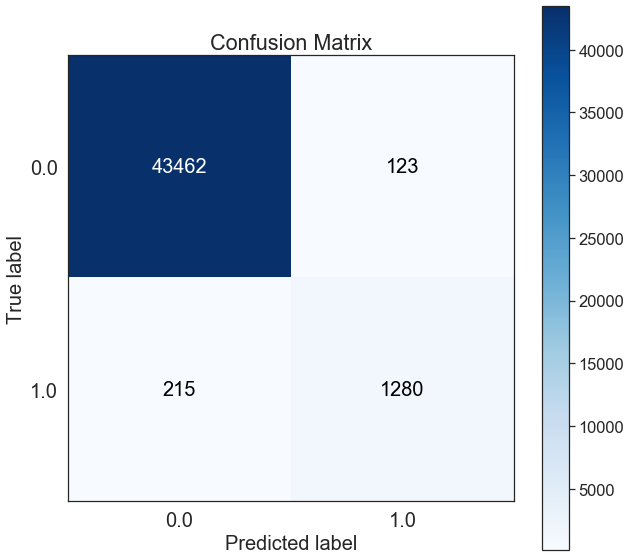

In [213]:
modified_ratio_uncombined_poly = evaluation(grid_xgb, X_val_poly, y_val_poly)

### feature importances

In [70]:
xgb = XGBClassifier(n_jobs=4,random_state=seed, gamma= 0, learning_rate = 0.2,
                        max_depth= 1, n_estimators = 500)

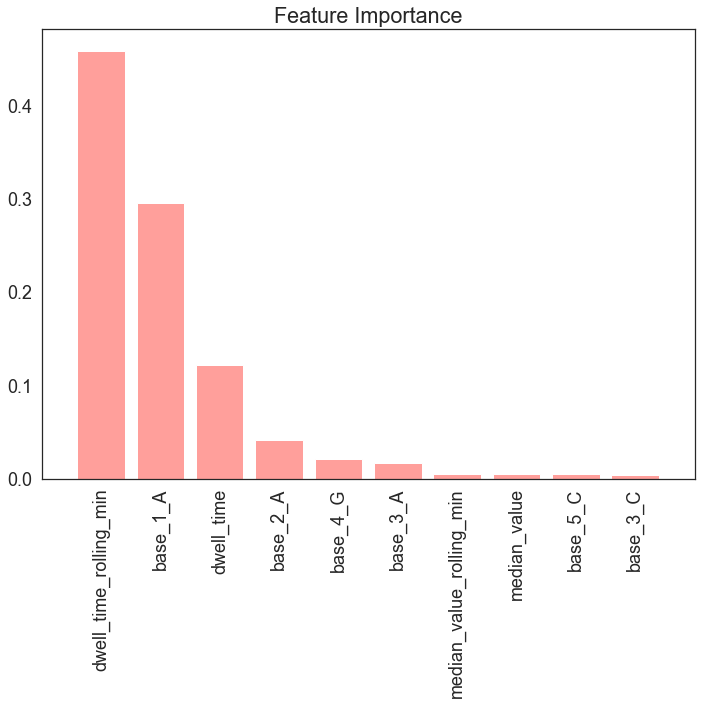

In [71]:
feature_importances(xgb, preprocessor_poly, X_finaltest_poly, y_finaltest_not_combined)

## classical models without bases

### model selection

In [116]:
sel_wo_bases = ModelSelector(preprocessor_not_combined_wo_bases, instance_name = "Uncombined Dataframe without bases")

In [117]:
sel_wo_bases.select_model(X_finaltest_not_combined, y_finaltest_not_combined, True)

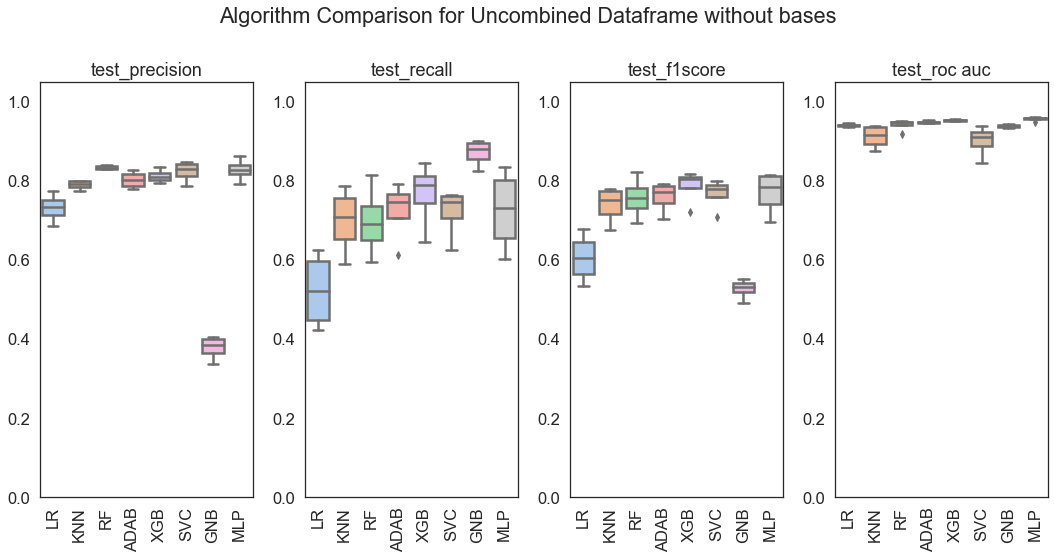

In [118]:
sel_wo_bases.plot_selection()

In [119]:
model_selection_results = pd.concat([model_selection_results,sel_wo_bases.get_scores()], axis=0)

### xgb gridsearch

In [214]:
param_grid_xgb = {'xgbclassifier__max_depth':[1],
                 'xgbclassifier__learning_rate':[0.2],
                 'xgbclassifier__n_estimators':[250],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0]}

In [215]:
xgb_clf = XGBClassifier(n_jobs=4,random_state=seed)
model_xgb = make_pipeline(preprocessor_not_combined_wo_bases,xgb_clf)

In [216]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)
grid_xgb.fit(X_finaltest_not_combined, y_finaltest_not_combined)
print(grid_xgb.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.6s finished


{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__max_depth': 1, 'xgbclassifier__n_estimators': 250}


------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     43585
         1.0       0.79      0.81      0.80      1495

    accuracy                           0.99     45080
   macro avg       0.89      0.90      0.90     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :39.57
Ratio of modified Reads for ref_pos 43 is :44.78
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 75 is :44.35
Ratio of modified Reads for ref_pos 81 is :44.78
Ratio of modified Reads for ref_pos 104 is :44.78
Ratio of modified Reads for ref_pos 123 is :45.22
Ratio of modified Reads for ref_pos 163 is :36.96
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified Reads for ref_pos 185 is :35.22
------------------------------


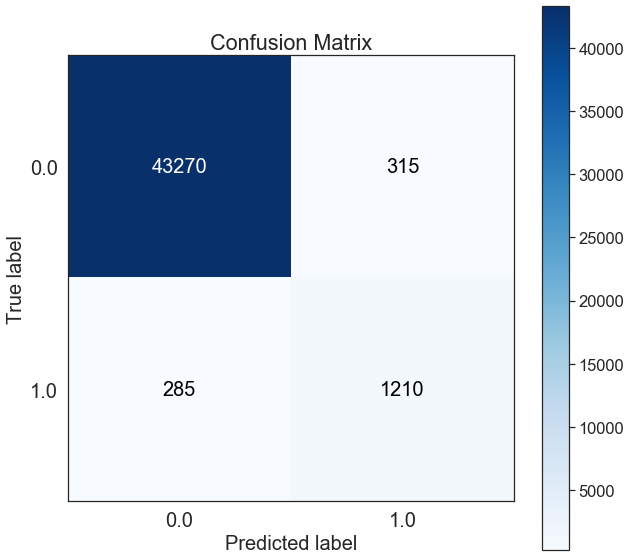

In [217]:
modified_ratio_uncombined_wo_bases = evaluation(grid_xgb, X_val_not_combined, y_val_not_combined)

### feature importances

In [89]:
xgb = XGBClassifier(n_jobs=-1,random_state=seed, gamma = 0, learning_rate = 0.2, max_depth = 1, n_estimators = 250)

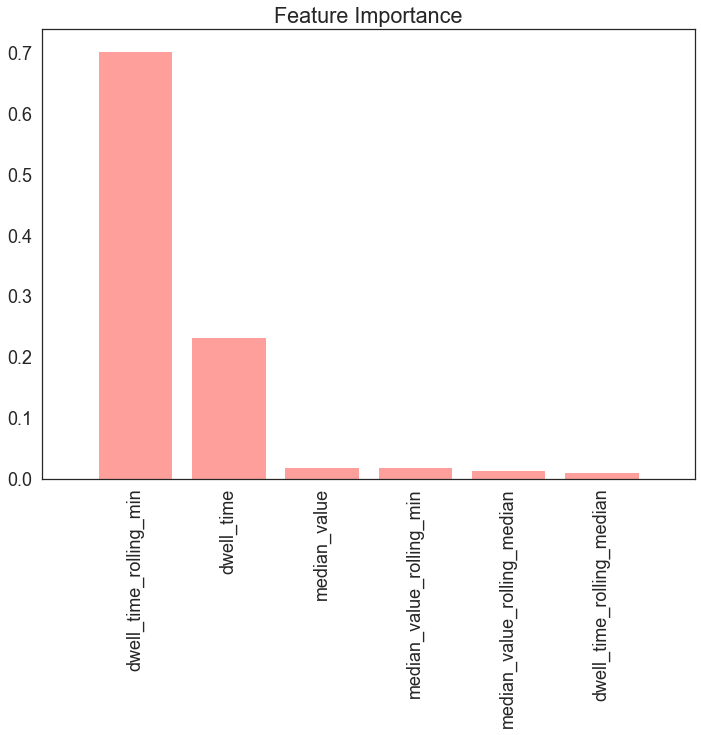

In [90]:
feature_importances(xgb, preprocessor_not_combined_wo_bases, X_finaltest_not_combined, y_finaltest_not_combined)

### yeast dataset

In [132]:
X_trans = preprocessor_not_combined_wo_bases.fit_transform(X_finaltest_not_combined)
X_yeast_trans = preprocessor_not_combined_wo_bases.fit_transform(df_yeast_not_combined)

In [133]:
xgb = XGBClassifier(n_jobs=4,random_state=seed, gamma= 0, learning_rate = 0.2,
                        max_depth= 1, n_estimators = 250)
xgb.fit(X_trans, y_finaltest_not_combined)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=None, n_estimators=250, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=7,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [134]:
y_yeast_pred = xgb.predict(X_yeast_trans)

In [135]:
df_yeast_not_combined["modified_status_predicted2"] = y_yeast_pred

In [136]:
df_yeast_group = df_yeast_not_combined.file_type.groupby(
    df_yeast_not_combined["modified_status_predicted2"]).value_counts(normalize=True).rename("wt_ko_ratio").reset_index()

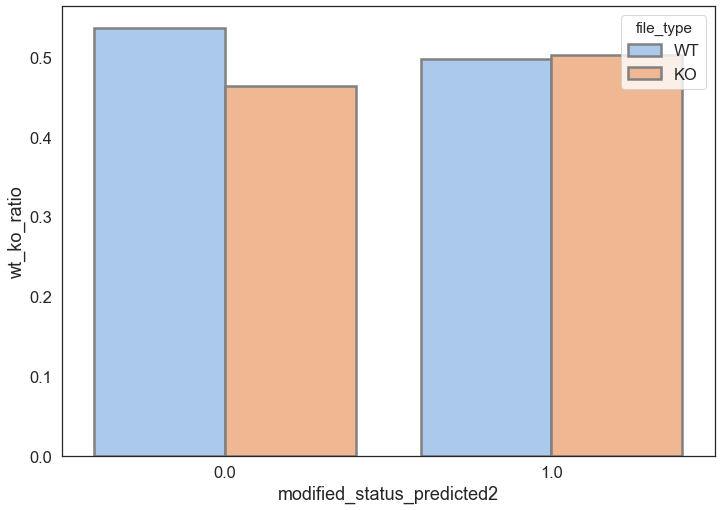

In [137]:
sns.barplot(data = df_yeast_group, x = "modified_status_predicted2",y = "wt_ko_ratio", hue = "file_type"
            ,edgecolor="grey" , linewidth = 2.5 );

In [138]:
df_yeast_group

,modified_status_predicted2,file_type,wt_ko_ratio
0,0.0,WT,0.536676
1,0.0,KO,0.463324
2,1.0,KO,0.502105
3,1.0,WT,0.497895


# supervised combined

## baseline

In [218]:
y_pred = np.zeros(len(X_val_combined))

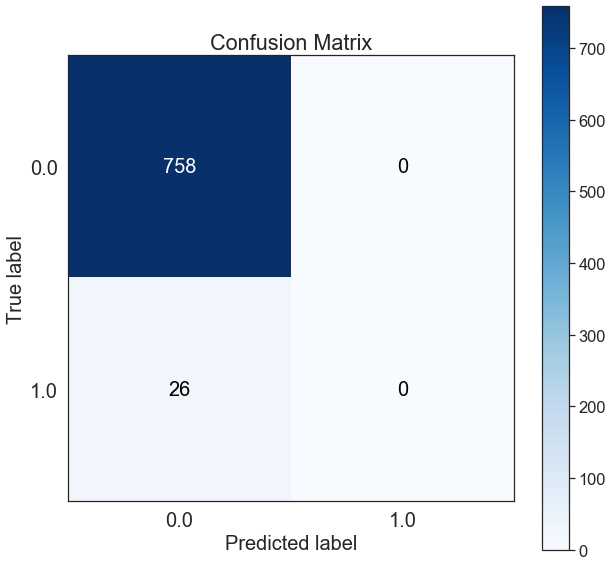

In [219]:
skplt.metrics.plot_confusion_matrix(y_val_combined, y_pred, figsize=(10,10), text_fontsize=20)

In [220]:
print(classification_report(y_val_combined,y_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       758
         1.0       0.00      0.00      0.00        26

    accuracy                           0.97       784
   macro avg       0.48      0.50      0.49       784
weighted avg       0.93      0.97      0.95       784



C:\Users\neomo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## classical ml models

### model selection

In [221]:
sel_c = ModelSelector(preprocessor_combined, instance_name = "Combined Dataframe")

In [222]:
sel_c.select_model(X_finaltest_combined, y_finaltest_combined, True)

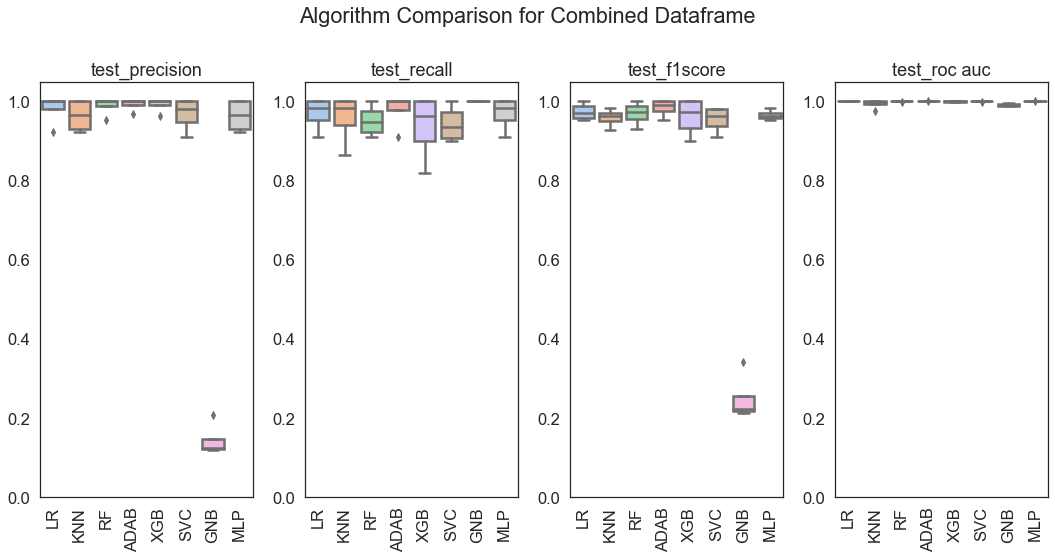

In [223]:
sel_c.plot_selection()

In [224]:
model_selection_results = pd.concat([model_selection_results,sel_c.get_scores()], axis=0)

### xgb gridsearch

In [225]:
param_grid_xgb = {'xgbclassifier__max_depth':[5],
                 'xgbclassifier__learning_rate':[0.3],
                 'xgbclassifier__n_estimators':[150],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0]}

In [226]:
xgb_clf = XGBClassifier(n_jobs = -1,random_state=seed)
model_xgb = make_pipeline(preprocessor_combined,xgb_clf)

In [227]:
labels = X_finaltest_combined.ref_number.values
cv_by_hand = [(np.where(labels != label)[0], np.where(labels == label)[0])
               for label in np.unique(labels)]

In [228]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs = -1,cv = cv_by_hand, verbose=3)
grid_xgb.fit(X_finaltest_combined, y_finaltest_combined)
print(grid_xgb.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 150}


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.9s finished


------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       758
         1.0       0.93      1.00      0.96        26

    accuracy                           1.00       784
   macro avg       0.96      1.00      0.98       784
weighted avg       1.00      1.00      1.00       784

------------------------------
Ratio of modified Reads for ref_pos 15 is :50.0
Ratio of modified Reads for ref_pos 26 is :50.0
Ratio of modified Reads for ref_pos 43 is :50.0
Ratio of modified Reads for ref_pos 58 is :50.0
Ratio of modified Reads for ref_pos 65 is :50.0
Ratio of modified Reads for ref_pos 74 is :50.0
Ratio of modified Reads for ref_pos 75 is :50.0
Ratio of modified Reads for ref_pos 81 is :50.0
Ratio of modified Reads for ref_pos 104 is :50.0
Ratio of modified Reads for ref_pos 123 is :50.0
Ratio of modified Reads for ref_pos 163 is :50.0
Ratio of modified Reads for ref_pos 169 is :50.0
Ratio of modified Reads for ref

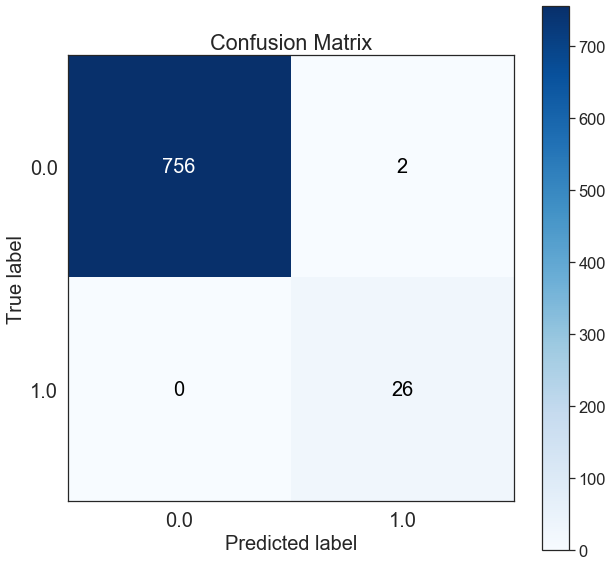

In [229]:
modified_ratio_combined = evaluation(grid_xgb, X_val_combined, y_val_combined)

### feature importances

In [151]:

xgb = XGBClassifier(n_jobs=4,random_state=seed, gamma= 0, learning_rate = 0.2,
                        max_depth= 1, n_estimators = 200)

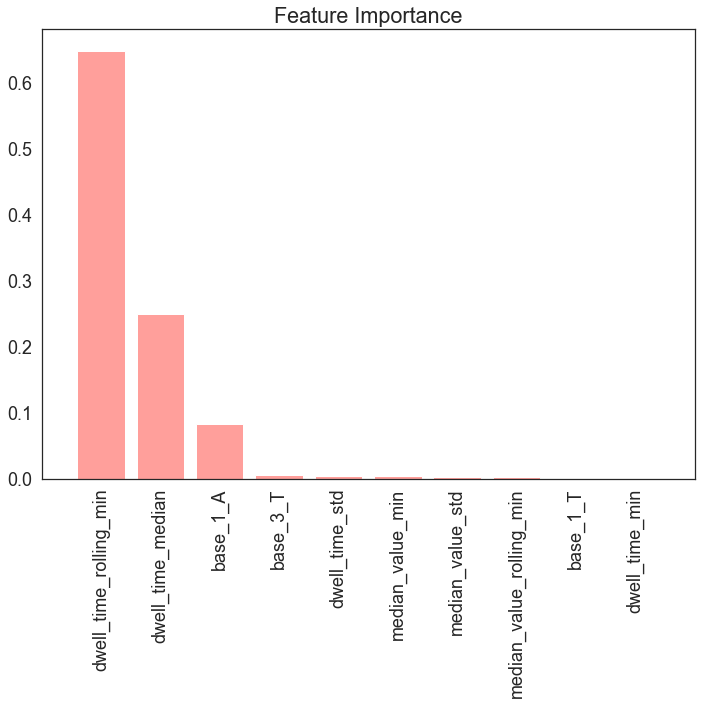

In [157]:
feature_importances(xgb, preprocessor_combined, X_finaltest_combined, y_finaltest_combined)

## classical ml models with oversampling

In [230]:
smotet = SMOTETomek(sampling_strategy = 'minority', random_state = seed, n_jobs = -1)


### model selection

In [231]:
sel_c_os = ModelSelector(preprocessor_combined, smotet, instance_name = "Combined Dataframe and Oversampling")

sel_c_os.select_model(X_finaltest_combined, y_finaltest_combined, True)

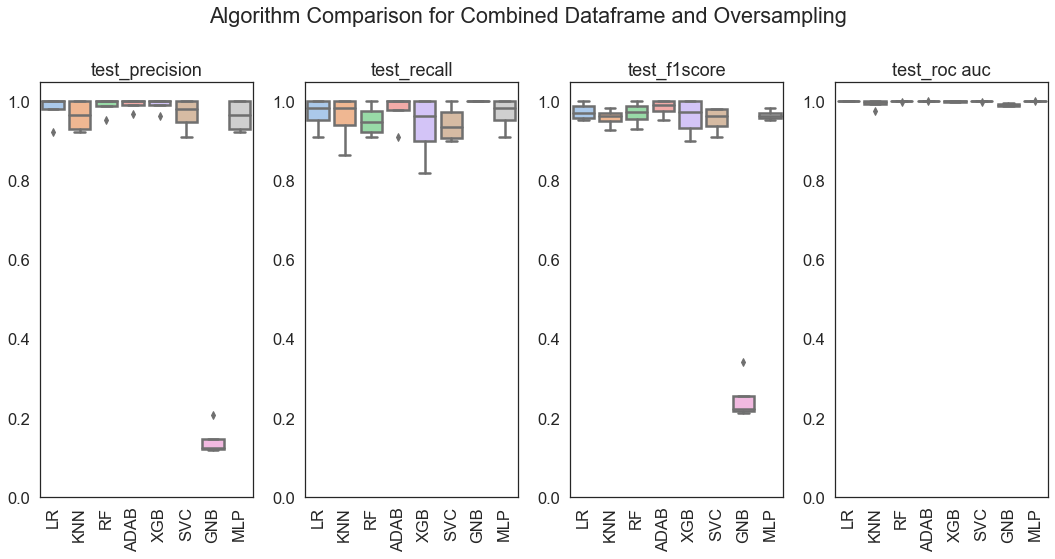

In [232]:
sel_c_os.plot_selection()

In [233]:
model_selection_results = pd.concat([model_selection_results,sel_c_os.get_scores()], axis=0)

In [234]:
model_selection_results = model_selection_results.reset_index()

In [235]:
model_selection_results

,instance_name,test,model,test_result
0,Combined Dataframe,test_precision,ADAB,0.991935
1,Combined Dataframe,test_precision,XGB,0.990741
2,Combined Dataframe,test_precision,RF,0.988095
3,Combined Dataframe,test_recall,GNB,1.000000
4,Combined Dataframe,test_recall,ADAB,0.977273
5,Combined Dataframe,test_recall,MLP,0.968939
6,Combined Dataframe,test_f1score,ADAB,0.983997
7,Combined Dataframe,test_f1score,LR,0.973858
8,Combined Dataframe,test_f1score,RF,0.969062
9,Combined Dataframe,test_roc auc,ADAB,1.000000


### xgb gridsearch

In [236]:
param_grid_xgb = {'xgbclassifier__max_depth':[1,2,5],
                 'xgbclassifier__learning_rate':[0.1],
                 'xgbclassifier__n_estimators':[100,200],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0]}

In [237]:
xgb_clf = XGBClassifier(n_jobs=4,random_state=seed)
model_xgb = Pipeline([("transformer",preprocessor_combined),("smt",smotet),("xgbclassifier",xgb_clf)])

In [238]:
labels = X_finaltest_combined.ref_number.values
cv_by_hand = [(np.where(labels != label)[0], np.where(labels == label)[0])
               for label in np.unique(labels)]

In [239]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)
grid_xgb.fit(X_finaltest_combined, y_finaltest_combined)
print(grid_xgb.best_params_)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  24 | elapsed:    0.8s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done  11 out of  24 | elapsed:    1.6s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:    2.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    5.7s finished


{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 100}


------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       758
         1.0       0.96      1.00      0.98        26

    accuracy                           1.00       784
   macro avg       0.98      1.00      0.99       784
weighted avg       1.00      1.00      1.00       784

------------------------------
Ratio of modified Reads for ref_pos 15 is :50.0
Ratio of modified Reads for ref_pos 26 is :50.0
Ratio of modified Reads for ref_pos 43 is :50.0
Ratio of modified Reads for ref_pos 58 is :50.0
Ratio of modified Reads for ref_pos 65 is :50.0
Ratio of modified Reads for ref_pos 75 is :50.0
Ratio of modified Reads for ref_pos 81 is :50.0
Ratio of modified Reads for ref_pos 104 is :50.0
Ratio of modified Reads for ref_pos 123 is :50.0
Ratio of modified Reads for ref_pos 163 is :50.0
Ratio of modified Reads for ref_pos 169 is :50.0
Ratio of modified Reads for ref_pos 179 is :50.0
Ratio of modified Reads for re

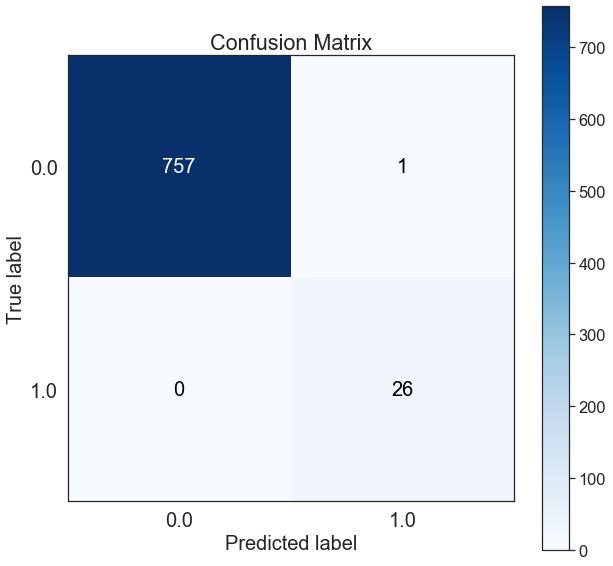

In [240]:
modified_ratio_combined_os = evaluation(grid_xgb, X_val_combined, y_val_combined)

# unsupervised

## TSNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
plt.figure(figsize = (20,40))

for perplexity in range (5,51,5):
    tsne = TSNE(random_state=7, perplexity = perplexity)
    tsne_combined = tsne.fit_transform(preprocessor_combined.fit_transform(df_combined))
    df_combined_w_tsne = pd.concat([df_combined,pd.Series(tsne_combined[:,0]).rename("tsne_d1"),
                      pd.Series(tsne_combined[:,1]).rename("tsne_d2")],axis=1, )
    plt.subplot(5,2,int(perplexity/5))
    sns.scatterplot(data = df_combined_w_tsne, x = "tsne_d1", y = "tsne_d2", hue = "modified_status_rolling_max")
    

## UMAP

In [ ]:
import umap

In [ ]:
umap = umap.UMAP()

In [ ]:
embedding = umap.fit_transform(preprocessor_combined.fit_transform(df_combined))

In [ ]:
umap_df = pd.DataFrame(embedding)

In [ ]:
umap_df["modified_status"] = df_combined["modified_status"].values
umap_df["file_type"] = df_combined["file_type"].values
umap_df["modified_neighbour"] = df_combined["modified_status_rolling_max"].values

In [ ]:
umap_df.columns = ["umap_dim_1","umap_dim_2","modified_status","file_type","modified_neighbour"]

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="umap_dim_2", y="umap_dim_1", data = umap_df, hue="modified_neighbour")


## kmeans

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(2, n_jobs = -1, random_state = seed)

In [ ]:
y_pred = kmeans.fit_predict(preprocessor_combined.fit_transform(df_combined))
y_true = df_combined["modified_status"].values

In [ ]:
adjusted_rand_score(y_true, y_pred)

In [ ]:
adjusted_mutual_info_score(y_true, y_pred)

## gmm

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
gmm = GaussianMixture(2, covariance_type="full")

In [ ]:
y_pred = gmm.fit_predict(preprocessor_combined.fit_transform(df_combined))
y_true = df_combined["modified_status"].values

In [ ]:
adjusted_rand_score(y_true, y_pred)


In [ ]:
adjusted_mutual_info_score(y_true, y_pred)

## hierarchical clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
y_pred = hc.fit_predict(preprocessor_combined.fit_transform(df_combined))

In [ ]:
adjusted_rand_score(y_true, y_pred)

In [ ]:
adjusted_mutual_info_score(y_true, y_pred)